![uproot logo](https://github.com/scikit-hep/uproot5/raw/main/docs-img/logo/logo-300px.png)

## Uproot + Dask: Lightning Talk

Authors: Kush Kothari \<kushkothari2001@gmail.com\> (Speaker), Dr Jim Pivarski \<pivarski@princeton.edu\>

In this short talk we introduce an important new feature in Uproot v5 (Target Release: Dec 2022), the `uproot.dask` function. This provides an excellent starting point in creating Dask workflows for HEP computations.

In [1]:
import numpy as np
from pprint import pprint as prettyprint

import uproot

Loading up some test data

In [2]:
import skhep_testdata

root_zmumu = skhep_testdata.data_path('uproot-Zmumu.root') + ":events"
root_hzz = skhep_testdata.data_path('uproot-HZZ.root') + ":events"
root_zmumu

'/home/kmk/.local/skhepdata/uproot-Zmumu.root:events'

### Eager workflows in Uproot

In [3]:
ttree = uproot.open(root_zmumu)
print(f"Ttree: {ttree}\n")

ak_arr = ttree.arrays() # This is when the TBranch data is read into memory
px = ak_arr['px1']
py = ak_arr['py1']
pt = np.sqrt(px**2 + py**2)
print(f"pt: {repr(pt)}")

Ttree: <TTree 'events' (20 branches) at 0x7f427fec8820>

pt: <Array [44.7, 38.8, 38.8, 37.8, ..., 32.4, 32.4, 32.5] type='2304 * float64'>


### Deprecating `uproot.lazy` in favour of Dask

Dask Collections provide many advantages, many of which were demonstrated in the [Dask tutorial by Doug Davis](https://indico.cern.ch/event/1150631/timetable/#37-dask-tutorial) just before this one.

The new function `uproot.dask` provides easy-to-use Dask workflows to delay and parallelize the file-reading functionality in Uproot.

In [4]:
import dask

In [5]:
## DON'T DO THIS
ttree = uproot.open(root_zmumu)
delayed_arr = dask.delayed(ttree['px1'].array)()
materialized_arr = delayed_arr.compute()
print(f"Output 1: {repr(materialized_arr)}\n")

## DO THIS INSTEAD
delayed_arr = uproot.dask(root_zmumu)['px1']
materialized_arr = delayed_arr.compute()
print(f"Output 2: {repr(materialized_arr)}\n")

Output 1: <Array [-41.2, 35.1, 35.1, 34.1, ..., 32.4, 32.4, 32.5] type='2304 * float64'>

Output 2: <Array [-41.2, 35.1, 35.1, 34.1, ..., 32.4, 32.4, 32.5] type='2304 * float64'>



Not only does `uproot.dask` make it more convenient to get Dask Collections from ROOT files, it actually does it better! Additionally we get use existing functionality from Uproot and Dask, like branch filters and chunking.

### So what does uproot.dask return?
Following Uproot conventions, `uproot.dask` takes in a `library=` argument that can currently be set to `'np'` or `'ak'`.

With `library='np'`, `uproot.dask` returns a Python dict of Dask Arrays

In [6]:
dask_array_dict = uproot.dask(root_zmumu, library='np')
prettyprint(dask_array_dict)

{'E1': dask.array<E1-from-uproot, shape=(2304,), dtype=float64, chunksize=(2304,), chunktype=numpy.ndarray>,
 'E2': dask.array<E2-from-uproot, shape=(2304,), dtype=float64, chunksize=(2304,), chunktype=numpy.ndarray>,
 'Event': dask.array<Event-from-uproot, shape=(2304,), dtype=int32, chunksize=(2304,), chunktype=numpy.ndarray>,
 'M': dask.array<M-from-uproot, shape=(2304,), dtype=float64, chunksize=(2304,), chunktype=numpy.ndarray>,
 'Q1': dask.array<Q1-from-uproot, shape=(2304,), dtype=int32, chunksize=(2304,), chunktype=numpy.ndarray>,
 'Q2': dask.array<Q2-from-uproot, shape=(2304,), dtype=int32, chunksize=(2304,), chunktype=numpy.ndarray>,
 'Run': dask.array<Run-from-uproot, shape=(2304,), dtype=int32, chunksize=(2304,), chunktype=numpy.ndarray>,
 'Type': dask.array<Type-from-uproot, shape=(2304,), dtype=object, chunksize=(2304,), chunktype=numpy.ndarray>,
 'eta1': dask.array<eta1-from-uproot, shape=(2304,), dtype=float64, chunksize=(2304,), chunktype=numpy.ndarray>,
 'eta2': dask.

With `library='ak'` (the default value), it returns a `dask-awkward` collection, a brand-new dask collection. Just like with Dask arrays, calling `compute()` on a Dask-Awkward array will execute the corresponding dask-graph resulting in a materialized Awkward Array

In [7]:
dak_array = uproot.dask(root_zmumu)
print(f"Dask-Awkward Array:\n{dak_array}\n")
print(f"Dask-Awkward Array Type:\n{type(dak_array)}\n")
print(f"Materialized Awkward Array:\n{repr(dak_array.compute())}\n")

Dask-Awkward Array:
dask.awkward<from-uproot, npartitions=1>

Dask-Awkward Array Type:
<class 'dask_awkward.core.Array'>

Materialized Awkward Array:
<Array [{Type: 'GT', Run: 148031, ...}, ...] type='2304 * {Type: string, Ru...'>



Obviously, Dask-Awkward supports jagged arrays and computations on these, just like Awkward.

To find out more about this project, check out: https://github.com/ContinuumIO/dask-awkward

In [8]:
uproot.dask(root_hzz)['Jet_Px'].compute()

<Array [[], [-38.9], [], ..., [-36.4, -15.3], []] type='2421 * var * float32'>

When multiple TTrees are provided, `uproot.dask` also concatenates the common TBranches

In [9]:
root_zmumu2 = skhep_testdata.data_path('uproot-Zmumu-zlib.root') + ":events"
# Let's think of this as another ROOT file with the same branches

print(uproot.dask(root_zmumu, library='np')['px1'])
print(uproot.dask([root_zmumu,root_zmumu2], library='np')['px1'])

dask.array<px1-from-uproot, shape=(2304,), dtype=float64, chunksize=(2304,), chunktype=numpy.ndarray>
dask.array<px1-from-uproot, shape=(4608,), dtype=float64, chunksize=(2304,), chunktype=numpy.ndarray>


### Chunking
As Doug explained, Dask collections can be looked at in terms of chunks. These act like smaller blocks of memory that can be loaded into computer memory at a time.

`uproot.dask` provides a `step_size` argument to provide control over this behaviour.

In [10]:
print(uproot.dask(root_zmumu, library='np')['px1'])
print(uproot.dask(root_zmumu, library='np', step_size=10)['px1'])
print(uproot.dask(root_zmumu, library='np', step_size="10KB")['px1'])

print()

print(uproot.dask(root_zmumu)['px1'])
print(uproot.dask(root_zmumu, step_size=10)['px1'])
print(uproot.dask(root_zmumu, step_size="10KB")['px1'])

dask.array<px1-from-uproot, shape=(2304,), dtype=float64, chunksize=(2304,), chunktype=numpy.ndarray>
dask.array<px1-from-uproot, shape=(2304,), dtype=float64, chunksize=(10,), chunktype=numpy.ndarray>
dask.array<px1-from-uproot, shape=(2304,), dtype=float64, chunksize=(1891,), chunktype=numpy.ndarray>

dask.awkward<px1, npartitions=1>
dask.awkward<px1, npartitions=231>
dask.awkward<px1, npartitions=18>


### Opening files
Normally, `uproot.dask` just opens the file to read and understand metadata (e.g. `fEntries`). No TBranch data is read until `compute()` is called on the collection.

However, if you wish to even skip the overhead of opening files till the `compute()` call, you may do so with `open_files=False`. When a list of files is provided with `open_files=False`, `uproot.dask` just opens the first file to get TBranch type metadata, and assumes the same set of TBranches for all the other files. The actual opening of the files is just delayed like a Dask task.

In [11]:
## Nothing really I can show for this, but except that the final arrays are the same! :)

print(uproot.dask([root_zmumu,root_zmumu2])['px1'].compute())
print(uproot.dask([root_zmumu,root_zmumu2],open_files=False)['px1'].compute())

[-41.2, 35.1, 35.1, 34.1, 22.8, -19.9, ..., 19, 19.1, -68, 32.4, 32.4, 32.5]
[-41.2, 35.1, 35.1, 34.1, 22.8, -19.9, ..., 19, 19.1, -68, 32.4, 32.4, 32.5]


## Delayed workflow using Dask

In [12]:
dask_arr_dict = uproot.dask(root_zmumu, library='np', step_size=1000)

px = dask_arr_dict['px1']
py = dask_arr_dict['py1']
pz = dask_arr_dict['pz1']
pt = np.sqrt(px**2 + py**2)
phi = np.arctan2(py, px)
eta = np.arcsinh(pz / pt)

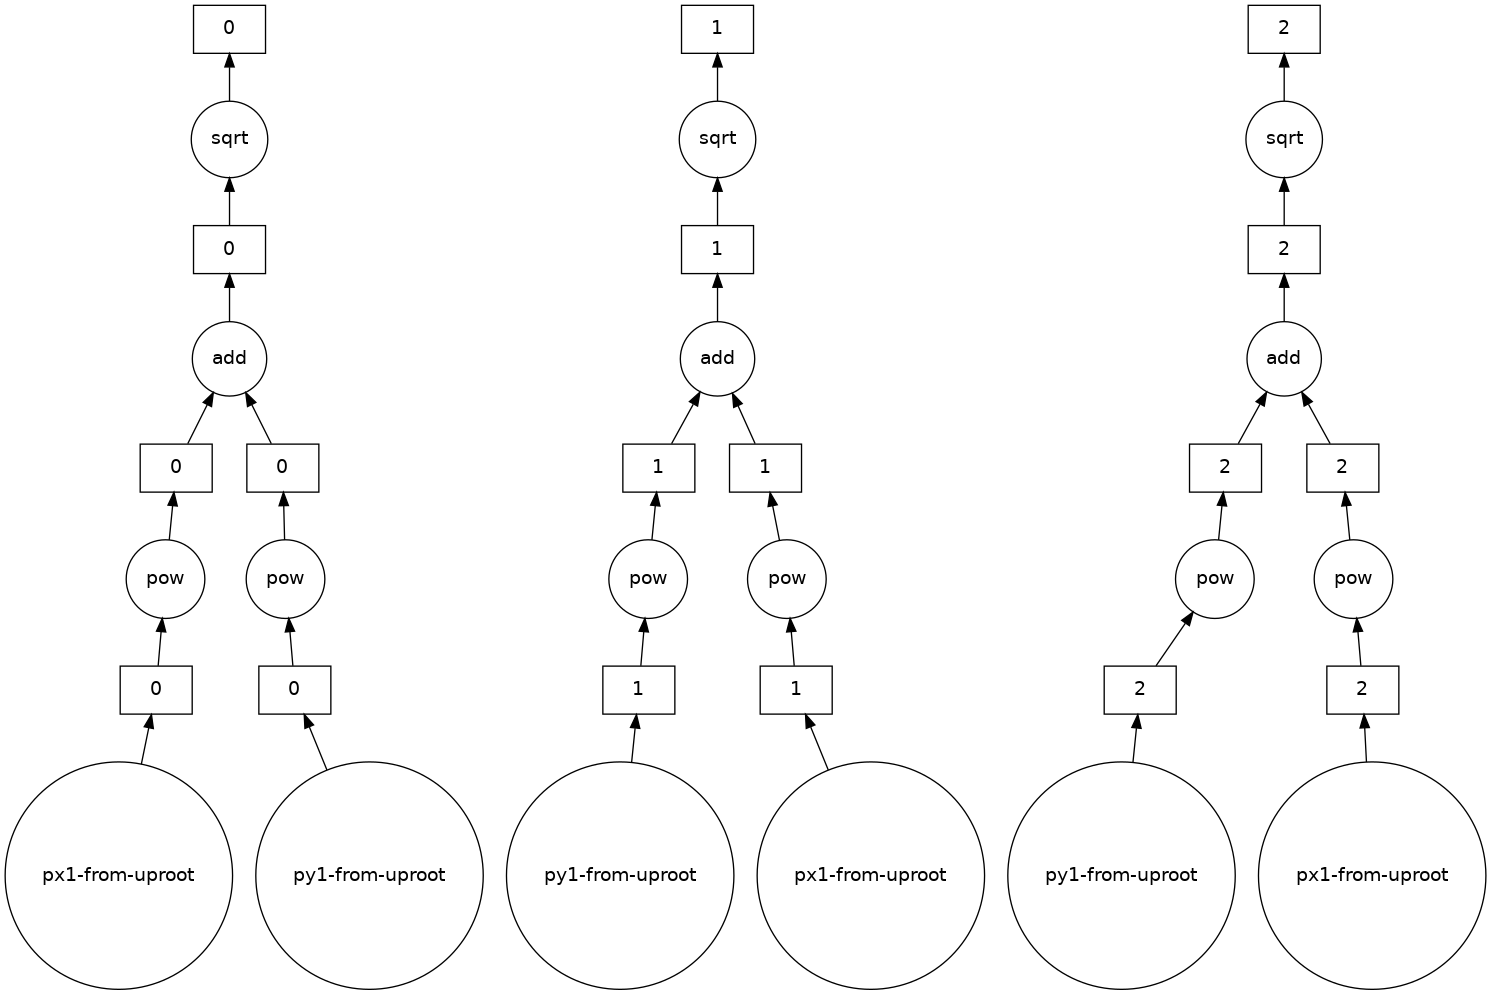

In [13]:
pt.visualize()

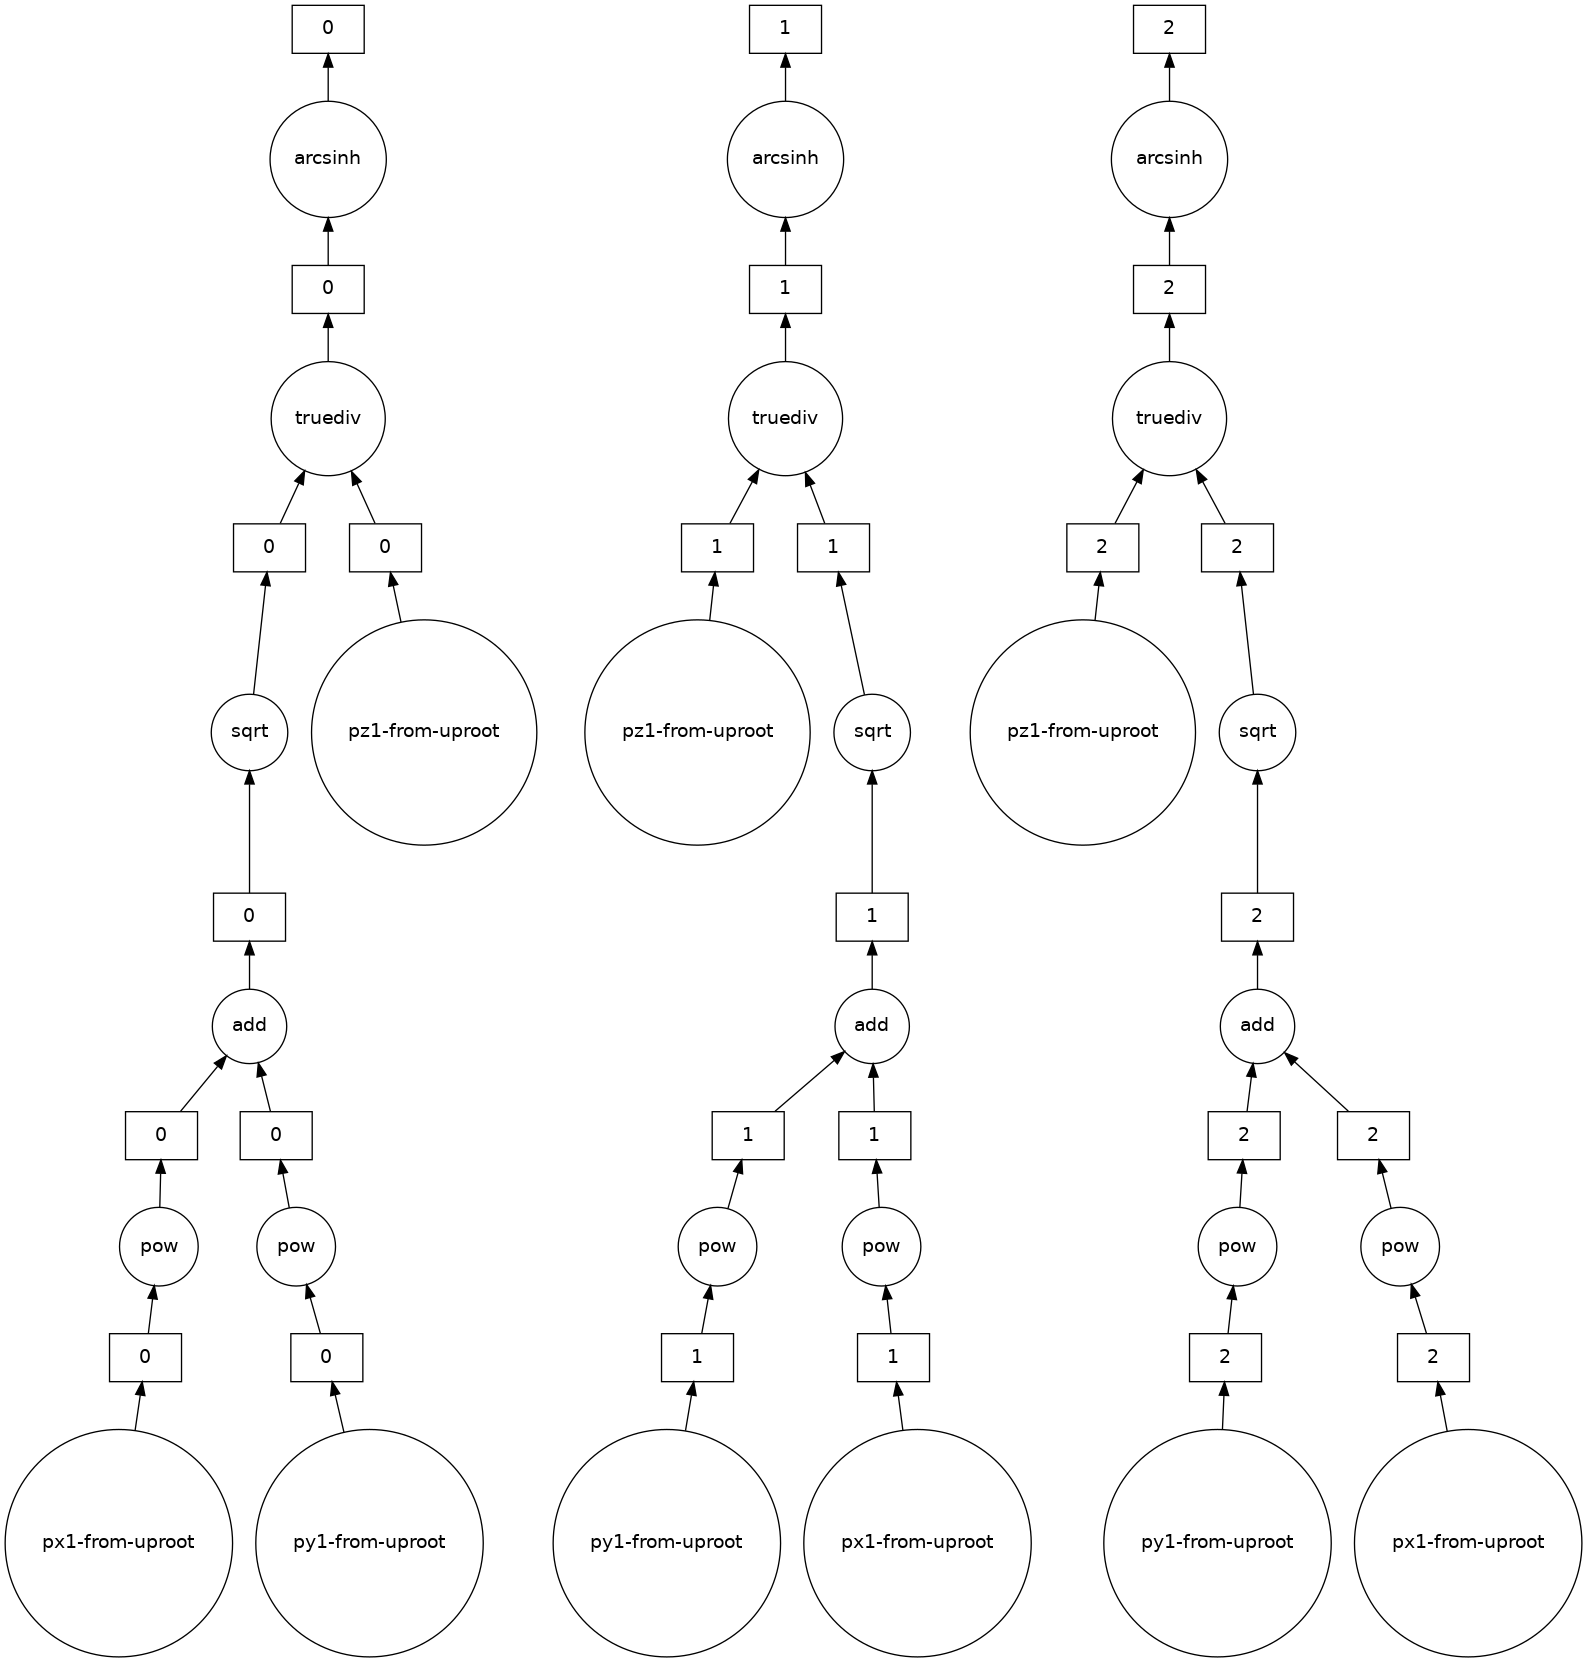

In [14]:
eta.visualize()

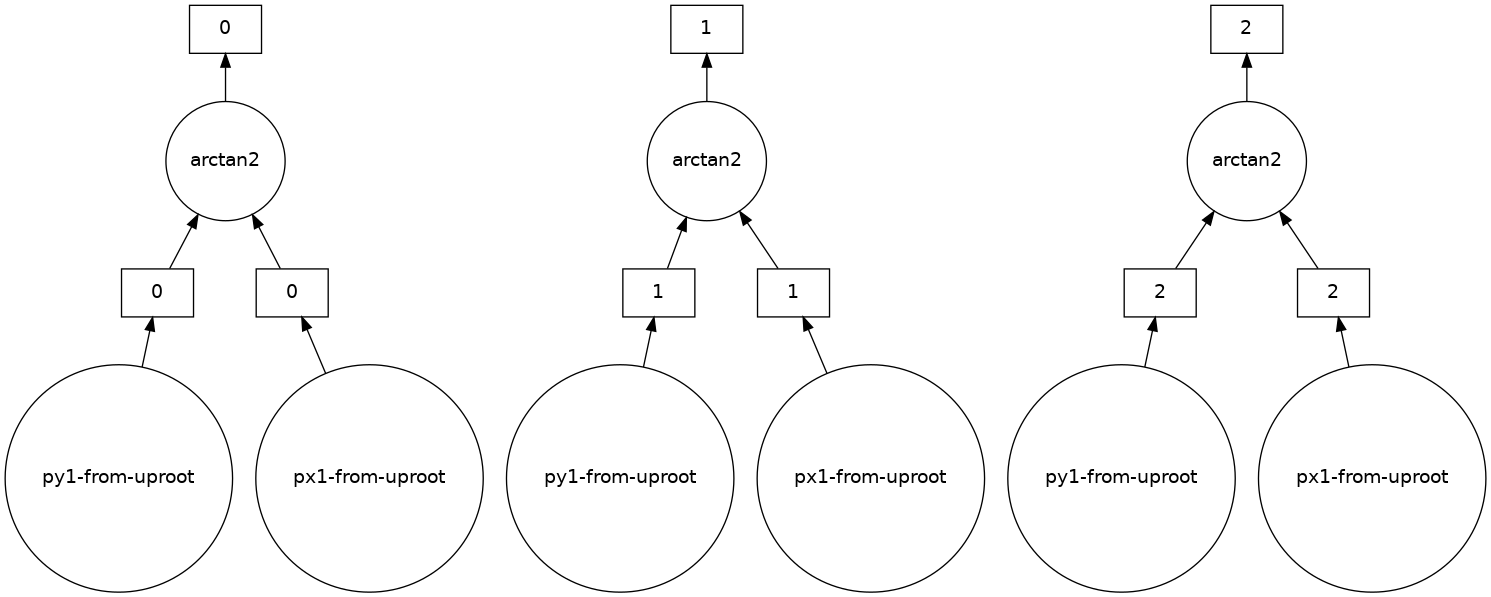

In [15]:
phi.visualize()

In [16]:
phi.compute()

array([ 2.74126  , -0.440873 , -0.440873 , ...,  0.0370275,  0.0370275,
        0.0369644])